# **Lasso and Ridge Regression using Polynomial Regression**

## Utility functions

In [ ]:
def stratified_train_test_split(X, y, split_ratio=0.7, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    class_indices = {}

    for class_label in np.unique(y):
        class_indices[class_label] = np.where(y == class_label)[0]

    train_indices = []
    test_indices = []

    # Performing stratified sampling
    for class_label, indices in class_indices.items():
        np.random.shuffle(indices)
        split_idx = int(len(indices) * split_ratio)
        train_indices.extend(indices[:split_idx])
        test_indices.extend(indices[split_idx:])

    # Spliting the data into training and test sets
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test

def plot_training_and_testing_loss(iterations, train_loss_values, test_loss_values, plot_both):

  # Plotting the number of iterations vs. training and testing loss
  if(plot_both):
    plt.plot(range(iterations), train_loss_values, label='Test Loss')
    plt.plot(range(iterations), test_loss_values, label='Training Loss')
  else:
    plt.plot(range(iterations), test_loss_values, label='Test Loss')

  plt.xlabel('Number of Iterations')
  plt.ylabel('Loss (MSE)')
  plt.title('Number of Iterations vs. Loss')
  plt.legend()
  plt.show()

def calculate_accuracy(predicted_probabilities, y_test):
    TP = sum((predicted_probabilities == 1) & (y_test == 1))
    TN = sum((predicted_probabilities == 0) & (y_test == 0))
    FP = sum((predicted_probabilities == 1) & (y_test == 0))
    FN = sum((predicted_probabilities == 0) & (y_test == 1))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0

    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0


    return accuracy, f1_score, precision, recall

##Polynomial Regression

In simple linear regression, a straight line is used to represent the relationship between variables, but in polynomial regression, higher-degree polynomial functions are used instead of a straight line.

The general form of a polynomial regression equation with one independent variable is:

$$y = b0 + b1 * x + b2 * x^2 + ... + bn * x^n$$

Here:

y represents the dependent variable.
x is the independent variable.
b0, b1, b2, ..., bn are coefficients to be estimated from the data.
n is the degree of the polynomial, which determines the order of the polynomial regression.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def polynomial_regression(degree, data, learning_rate, iterations, alpha, plot, plot_both):
    data = pd.read_csv("sampled_data.csv")
    y = data["Outcome"].values.reshape(-1, 1)

    X = data.drop("Outcome", axis=1).values

    # Function to add polynomial features
    def add_polynomial_features(X, degree):
        n_samples, n_features = X.shape
        X_poly = X.copy()
        for d in range(2, degree + 1):
            for feature in range(n_features):
                new_feature = X[:, feature] ** d
                X_poly = np.column_stack((X_poly, new_feature))
        return X_poly

    X_poly = add_polynomial_features(X, degree)

    # Normalizing the input features (standardization)
    mean = np.mean(X_poly, axis=0)
    std = np.std(X_poly, axis=0)
    X_normalized = (X_poly - mean) / std

    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

    # Initializing coefficients with ones
    theta = np.ones((X_train.shape[1], 1))

    train_loss_values = []
    test_loss_values = []

    for _ in range(iterations):
        # Calculating predictions
        predictions = 1 / (1 + np.exp(-np.dot(X_train, theta)))

        # Calculating the MSE loss
        mse_loss = np.mean((y_train - predictions) ** 2)

        gradient = 2 * np.dot(X_train.T, (y_train - predictions)) / X_train.shape[0]

        theta += learning_rate * gradient

        #Calculating Mean Squared Error (MSE) loss on the training data for this iteration
        train_predictions = 1 / (1 + np.exp(-np.dot(X_train, theta)))
        train_mse_loss = np.mean((y_train - train_predictions) ** 2)

        # Calculating MSE loss on the test data for this iteration
        test_predictions = 1 / (1 + np.exp(-np.dot(X_test, theta)))
        test_mse_loss = np.mean((y_test - test_predictions) ** 2)

        train_loss_values.append(train_mse_loss)
        test_loss_values.append(test_mse_loss)

    # Predictions on the testing data
    predicted_probabilities = 1 / (1 + np.exp(-np.dot(X_test, theta)))

    # Converting predicted probabilities to 0 or 1 based on a threshold
    threshold = np.mean(predicted_probabilities)
    predicted_classes = (predicted_probabilities >= threshold).astype(int)

    if(plot):
      plot_training_and_testing_loss(iterations, train_loss_values, test_loss_values, plot_both)

    # Computing accuracy on the testing data
    accuracy = accuracy_score(y_test, predicted_classes)

    return accuracy

In [ ]:
accuracies = []
for it in range(2, 10):
  print("Degree",it , "Accuracy =",polynomial_regression(it, df_sampl, 0.001, 10000, 0.01, False, False))

Degree 2 Accuracy = 0.62
Degree 3 Accuracy = 0.64
Degree 4 Accuracy = 0.63
Degree 5 Accuracy = 0.63
Degree 6 Accuracy = 0.63
Degree 7 Accuracy = 0.63
Degree 8 Accuracy = 0.64
Degree 9 Accuracy = 0.66


## **_Lasso Regression_**

Lasso regression is a linear regression technique that is used for feature selection and regularization. It stands for "Least Absolute Shrinkage and Selection Operator." Lasso regression adds a penalty term to the linear regression cost function, which encourages some of the model's coefficients to be exactly zero. This leads to feature selection, where some of the independent variables are effectively eliminated from the model.

The lasso regression cost function is typically expressed as:

$$Cost = RSS + λ *\sum_{i=1}^{n} |bi|$$


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def polynomial_regression_lasso(degree, data, learning_rate, iterations, alpha, plot, plot_both):

    data = pd.read_csv("sampled_data.csv")

    y = data["Outcome"].values.reshape(-1, 1)

    X = data.drop("Outcome", axis=1).values

    # Function to add polynomial features
    def add_polynomial_features(X, degree):
        n_samples, n_features = X.shape
        X_poly = X.copy()
        for d in range(2, degree + 1):
            for feature in range(n_features):
                new_feature = X[:, feature] ** d
                X_poly = np.column_stack((X_poly, new_feature))
        return X_poly

    # Adding polynomial features to training data
    X_poly = add_polynomial_features(X, degree)

    # Normalizing the input features (standardization)
    mean = np.mean(X_poly, axis=0)
    std = np.std(X_poly, axis=0)
    X_normalized = (X_poly - mean) / std

    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2,random_state=42, stratify=y)

    theta = np.ones((X_train.shape[1], 1))

    train_loss_values = []
    test_loss_values = []

    for _ in range(iterations):
        predictions = 1 / (1 + np.exp(-np.dot(X_train, theta)))

        # Calculating the MSE loss
        mse_loss = np.mean((y_train - predictions) ** 2)

        gradient = 2 * np.dot(X_train.T, (y_train - predictions)) / X_train.shape[0]

        # Adding Lasso (L1) regularization term to the gradient
        lasso_penalty = alpha * np.sign(theta)  # L1 penalty term
        gradient += lasso_penalty

        theta += learning_rate * gradient

        # Calculating Mean Squared Error (MSE) loss on the training data for this iteration
        train_predictions = 1 / (1 + np.exp(-np.dot(X_train, theta)))
        train_mse_loss = np.mean((y_train - train_predictions) ** 2)

        # Calculating MSE loss on the test data for this iteration
        test_predictions = 1 / (1 + np.exp(-np.dot(X_test, theta)))
        test_mse_loss = np.mean((y_test - test_predictions) ** 2)

        train_loss_values.append(train_mse_loss)
        test_loss_values.append(test_mse_loss)

    # Predictions on the testing data
    predicted_probabilities = 1 / (1 + np.exp(-np.dot(X_test, theta)))

    # Converting predicted probabilities to 0 or 1 based on a threshold
    threshold = np.median(predicted_probabilities)
    predicted_probabilities = (predicted_probabilities >= threshold).astype(int)

    if(plot):
      plot_training_and_testing_loss(iterations, train_loss_values, test_loss_values, plot_both)

    accuracy = accuracy_score(predicted_probabilities, y_test)

    return accuracy

In [ ]:
accuracies = []
for it in range(2, 10):
  print("Degree",it , "Accuracy =",polynomial_regression_lasso(it, df_sampl, 0.001, 10000, 0.01, False, False))

Degree 2 Accuracy = 0.73
Degree 3 Accuracy = 0.75
Degree 4 Accuracy = 0.73
Degree 5 Accuracy = 0.73
Degree 6 Accuracy = 0.73
Degree 7 Accuracy = 0.73
Degree 8 Accuracy = 0.73
Degree 9 Accuracy = 0.71


## **_Ridge Regression_**

Ridge regression is another linear regression technique used for regularization. Like lasso regression, ridge regression adds a penalty term to the linear regression cost function, but instead of using the absolute values of coefficients, it uses the squares of coefficients. This penalty encourages the coefficients to be small but not necessarily zero.

The ridge regression cost function is typically expressed as:

$$Cost = RSS + λ *\sum_{i=1}^{n} bi^2$$


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def polynomial_regression_ridge(degree, data, learning_rate, iterations, alpha, plot, plot_both):

    data = pd.read_csv("sampled_data.csv")

    y = data["Outcome"].values.reshape(-1, 1)

    X = data.drop("Outcome", axis=1).values

    # Function to add polynomial features
    def add_polynomial_features(X, degree):
        n_samples, n_features = X.shape
        X_poly = X.copy()
        for d in range(2, degree + 1):
            for feature in range(n_features):
                new_feature = X[:, feature] ** d
                X_poly = np.column_stack((X_poly, new_feature))
        return X_poly

    # Adding polynomial features to training data
    X_poly = add_polynomial_features(X, degree)

    # Normalizing the input features (standardization)
    mean = np.mean(X_poly, axis=0)
    std = np.std(X_poly, axis=0)
    X_normalized = (X_poly - mean) / std

    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2,random_state=42, stratify=y)

    theta = np.ones((X_train.shape[1], 1))

    train_loss_values = []
    test_loss_values = []

    for _ in range(iterations):
        predictions = 1 / (1 + np.exp(-np.dot(X_train, theta)))

        # Calculating the MSE loss
        mse_loss = np.mean((y_train - predictions) ** 2)

        gradient = 2 * np.dot(X_train.T, (y_train - predictions)) / X_train.shape[0]

        # Adding Ridge (L2) regularization term to the gradient
        ridge_penalty = 2 * alpha * theta  # L2 penalty term
        gradient -= ridge_penalty

        theta += learning_rate * gradient

        # Calculating Mean Squared Error (MSE) loss on the training data for this iteration
        train_predictions = 1 / (1 + np.exp(-np.dot(X_train, theta)))
        train_mse_loss = np.mean((y_train - train_predictions) ** 2)

        # Calculating MSE loss on the test data for this iteration
        test_predictions = 1 / (1 + np.exp(-np.dot(X_test, theta)))
        test_mse_loss = np.mean((y_test - test_predictions) ** 2)

        train_loss_values.append(train_mse_loss)
        test_loss_values.append(test_mse_loss)

    predicted_probabilities = 1 / (1 + np.exp(-np.dot(X_test, theta)))

    # Converting predicted probabilities to 0 or 1 based on a threshold
    threshold = np.mean(predicted_probabilities)

    predicted_probabilities = (predicted_probabilities >= threshold).astype(int)

    if(plot):
      plot_training_and_testing_loss(iterations, train_loss_values, test_loss_values, plot_both)

    accuracy = accuracy_score(predicted_probabilities, y_test)

    return accuracy

In [ ]:
accuracies = []
for it in range(2, 9):
  print("Degree",it , "Accuracy =",polynomial_regression_ridge(it, df_sampl, 0.001, 10000, 0.01, False, False))

Degree 2 Accuracy = 0.73
Degree 3 Accuracy = 0.76
Degree 4 Accuracy = 0.76
Degree 5 Accuracy = 0.75
Degree 6 Accuracy = 0.75
Degree 7 Accuracy = 0.75
Degree 8 Accuracy = 0.75


## **_Insights drawn (plots, markdown explanations)_**

####Training and testing loss for polynomial regression, lasso regression and ridge regression

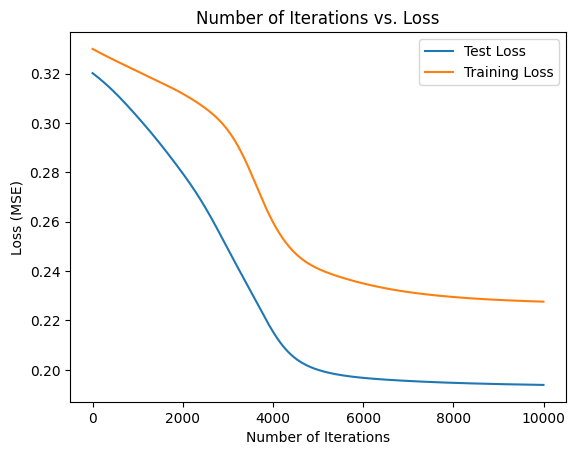

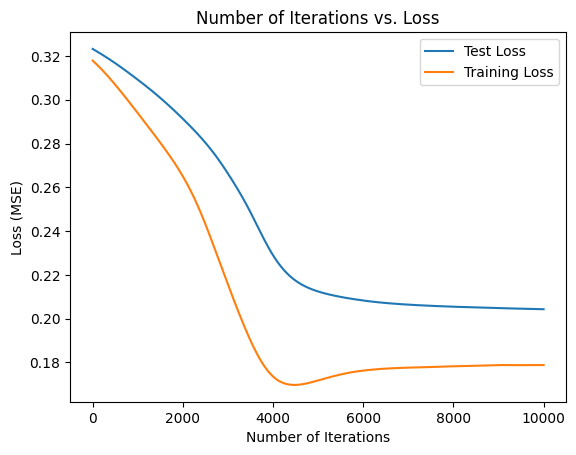

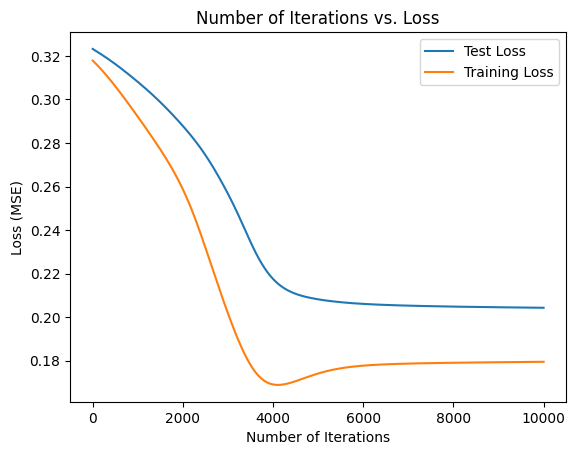

0.76

In [ ]:
polynomial_regression(4, df_sampl, 0.001, 10000, 0.01, True, True)
polynomial_regression_lasso(4, df_sampl, 0.001, 10000, 0.01, True, True)
polynomial_regression_ridge(4, df_sampl, 0.001, 10000, 0.01, True, True)

####Test loss for polynomial regression, lasso regression and ridge regression

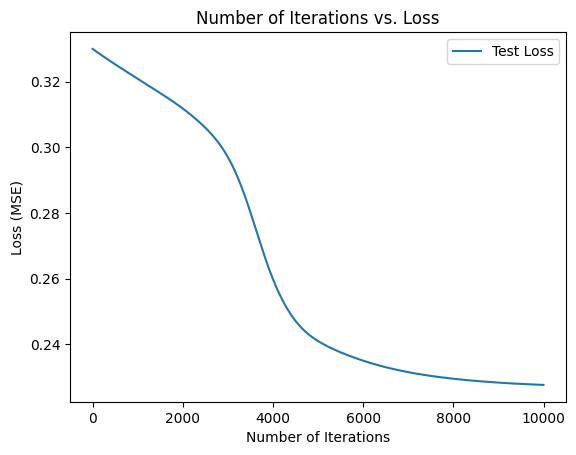

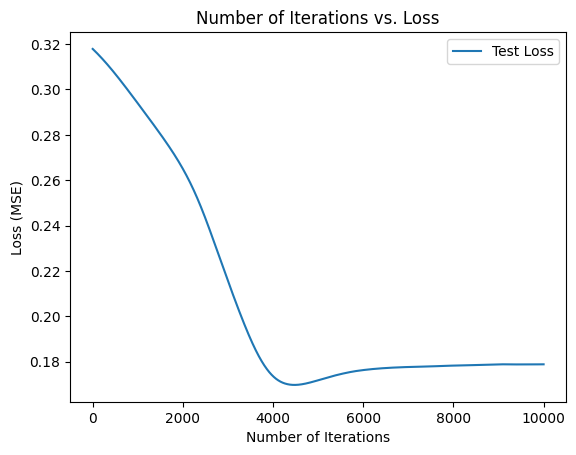

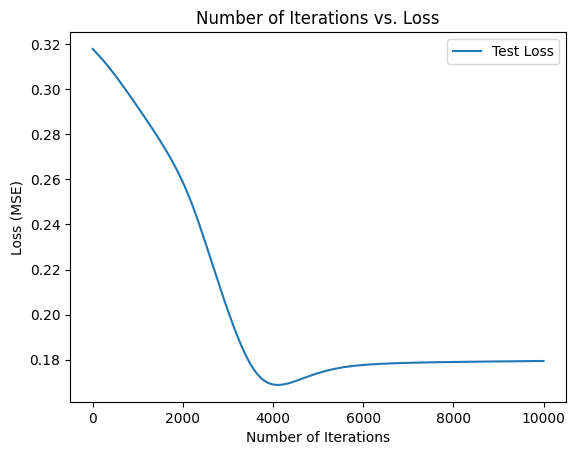

0.76

In [ ]:
polynomial_regression(4, df_sampl, 0.001, 10000, 0.01, True, False)
polynomial_regression_lasso(4, df_sampl, 0.001, 10000, 0.01, True, False)
polynomial_regression_ridge(4, df_sampl, 0.001, 10000, 0.01, True, False)

####Testing loss for varying lambda (lasso regression)

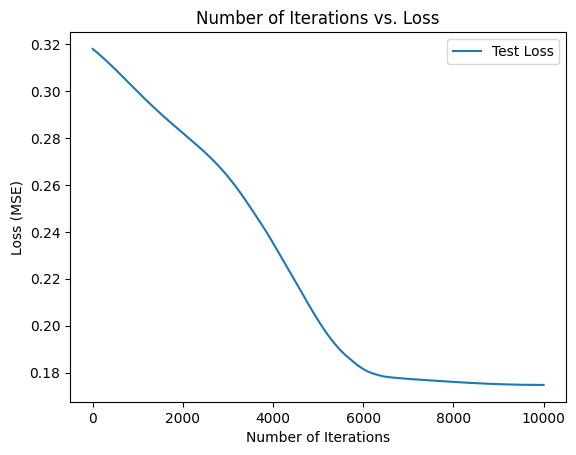

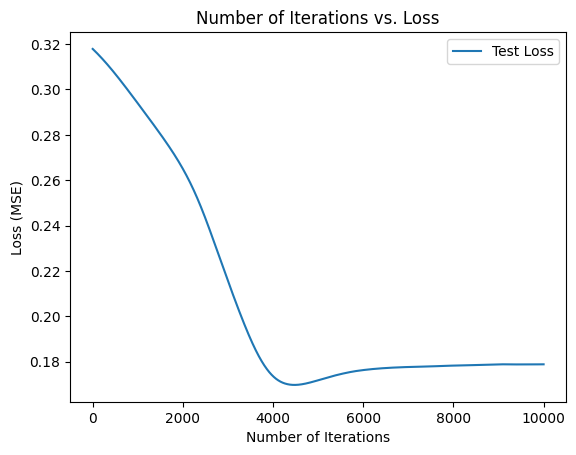

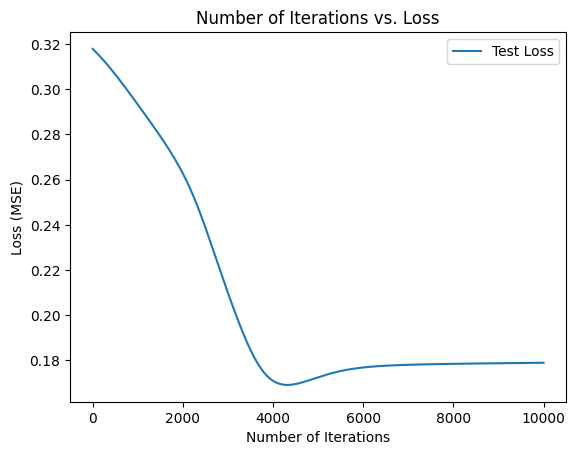

0.75

In [ ]:
polynomial_regression_lasso(4, df_sampl, 0.001, 10000, 0.1, True, False)
polynomial_regression_lasso(4, df_sampl, 0.001, 10000, 0.01, True, False)
polynomial_regression_lasso(4, df_sampl, 0.001, 10000, 0.001, True, False)

####Testing loss for varying lambda (ridge regression)

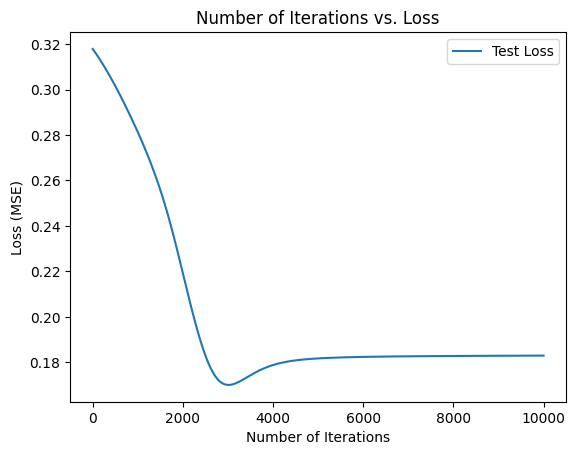

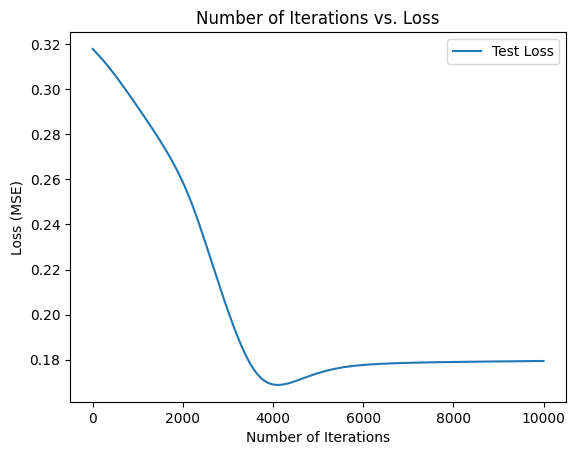

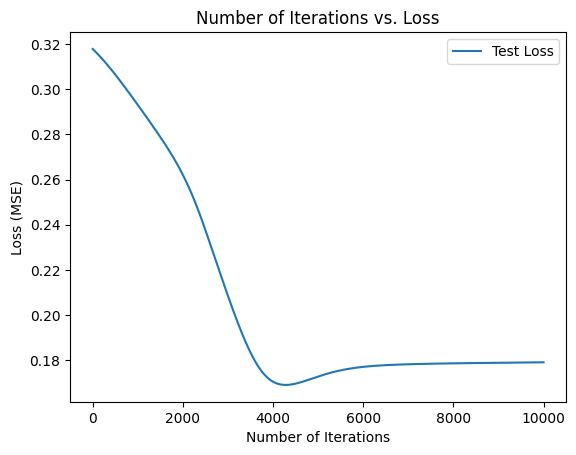

0.75

In [ ]:
polynomial_regression_ridge(4, df_sampl, 0.001, 10000, 0.1, True, False)
polynomial_regression_ridge(4, df_sampl, 0.001, 10000, 0.01, True, False)
polynomial_regression_ridge(4, df_sampl, 0.001, 10000, 0.001, True, False)